# Background

PcMag released an article of the [top 60 wfh](https://apple.news/AA6GPTj-UTEiMcpYbRDMKug) locations ([on gDocs](https://docs.google.com/document/d/1kzVOcWb-QCCeZkJyw8WEcWfJkllwU9j4PLBzQekR4to/edit)). This notebook is for visualizing that data in a more intuitive manner.

## Vision Board

1. user opens page. be shown map of USA and CA. cities in our database show as bold dots (like on a real map). at the top are the filter selection bars (like airbnb... select your dates, select weather preference, parks per 100k, internet speed, etc etc. )
2. map highlights cities that match the filters by making those dots big bold and blue, and other dots small and gray. 
3. when user hovers over one of the dots, we show a card [like this one](https://ant.design/components/card/). Title of city at top of card, then image of city, then the data we have on it, then description of the city, and at the bottom of the card a big 'SEARCH ON AIRBNB' button. 
4. when they click the airbnb button it takes them to the airbnb search page for that city. [Example](https://www.airbnb.com/s/Chattanooga--TN--United-States/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&date_picker_type=calendar&query=Chattanooga%2C%20TN%2C%20United%20States&place_id=ChIJheeDikBgYIgRqiiHiR8mcSQ&checkin=2021-02-03&checkout=2021-02-25&adults=2&source=structured_search_input_header&search_type=autocomplete_click)

## Example Data

1. CHATTANOOGA, TN
Lowest cost for gigabit broadband: $60
Provider: AT&T Fiber 
Median home price: $186,500 
Median home size: 5.2 rooms 
Coffee shops per 100K: 27 
Parks per 100K: 14 
Non-chain restaurants: 74% 
Workers in arts and education: 8.4% 
Health care practitioners: 4.5% 
Workers at home: 4.7% 
The American South boasts many grand old cities with rich histories, but Chattanooga is number one on our list. It’s also known as Gig City: Chattanooga was the first US city to roll out a citywide gigabit network, and it’s become a major tech hub since then. But it’s also on top thanks to its low cost of living and array of family-friendly attractions. The city is home to the Tennessee Aquarium, the Bluff View Art District, and the Chattanooga Choo Choo, a popular community known for its restaurants and live music.

2. BEAR VALLEY SPRINGS, CA
Population: 5,389 
Lowest cost for gigabit broadband: $60 
Provider: Race Communications 
Median home price: $357,800 
Median home size: 6 rooms 
Coffee shops per 100K: 18 
Parks per 100K: 15 
Non-chain restaurants: 74% 
Workers in arts and education: 10.1% 
Health care practitioners: 7.7% 
Workers at home: 12.8% 
If you’re looking to make a mountain retreat your new home, consider Bear Valley Springs, a private, gated community nestled in the Tehachapi Mountains. According to Wikipedia, this town offers pleasantly cooler weather than surrounding places during the summer; you’ll definitely see snow in the winter. You can also take a look at nearby Stallion Springs and Golden Hills for remote-working arrangements. The population is just under 5,400, and many residents are retirees.

3. PAWLET, VT
Population: 1,344 
Lowest cost for gigabit broadband: $70 
Provider: Vermont Telephone Company 
Median home price: $221,500 
Median home size: 6 rooms 
Coffee shops per 100K: 32 
Parks per 100K: 22 
Non-chain restaurants: 90% 
Workers in arts and education: 16.4% 
Health care practitioners: 2.5% 
Workers at home: 11.1% 
The gorgeous Taconic Mountains in Vermont are hiding a gem of a country town called Pawlet, which offers incredible mountain views and quiet country living. Its population is just 1,344 people, so you’re certain to get to know your neighbors fast. The town is home to 22 parks and 32 coffee shops, and most of the restaurants are independently owned. Also consider nearby Springfield and Mount Holly, highly rated southern Vermont towns serviced by Vermont Telephone Company (VTel) for broadband connectivity.


# Import Data

In [1]:
import pandas as pd
import numpy as np
import codecs # to avoid "ascii codec cant decode byte ..." error
import re # to extract info

## As String

In [2]:
with codecs.open("pcmag_wfh_article.txt","r",encoding="utf-8") as f:
    wfh_str = f.read()

In [3]:
len(wfh_str.split("\n"))

793

## As List

In [4]:
import codecs
with codecs.open("pcmag_wfh_article.txt", "r",encoding='utf-8') as f:
    wfh_list = []
    for item in f:
        wfh_list.append(item)

In [5]:
len(wfh_list)

793

# Extract Data

Each city has different stats variables, we don't know which city is missing what. Grab info by paragraphs (chunks), and then parse one chunk at a time.

Final dataset should look like:

| city | population | web_cost | web_provider | median_home_price | median_home_size | coffee_shops_100k | parks_100k | restaurants | arts_edu_workers | health_workers | wfh | description |
|------|------------|----------|--------------|-------------------|------------------|-------------------|------------|-------------|------------------|----------------|-----|-------------|
|      |            |          |              |                   |                  |                   |            |             |                  |                |     |             |

In [16]:
cities = re.findall("\d\d?\.\s.+?(?=\n)",wfh_str)

In [17]:
# The 00s were descriptions, get rid of these
for x in cities:
    if '00.' in x:
        cities.remove(x)

In [18]:
# Create a clean list of just USA cities
usa_cities = []
for x in cities[3:-10]:
    usa_cities.append(x.replace('\r',''))
    
# get just the city and states
pattern = '\d\d?\. '
clean_cities = [re.sub(pattern, '',x) for x in usa_cities]

In [19]:
clean_cities[-5:]

['SHALLOTTE, NC',
 'KENSINGTON PARK, FL',
 'BROOKLYN PARK, MN',
 'ARLINGTON, WA',
 'BEACHWOOD, NJ']

In [20]:
wfh_data = wfh_list[41:] # cut off intro

In [21]:
city_starts = []

In [22]:
# Get starting loc of each city in series
for i in range(len(clean_cities)):
    city = clean_cities[i]
    for i, s in enumerate(wfh_data):
        if city in s:
            city_starts.append(i)

In [23]:
city_starts[:5]

[0, 12, 25, 38, 51]

In [24]:
# get range of relevant data for each city
location_ranges = {}
for i in range(len(city_starts)):
    this_ = clean_cities[i] # current city
    try:
        start_ = city_starts[i] # start of current city's data
        end_ = city_starts[i+1] # start of next city's data
    except:
        start_ = city_starts[i]
        end_ = len(wfh_data) # last city
    location_ranges[this_] = [start_, end_] # add range to dictionary

In [25]:
# store each city's relevant data in dict
city_data = {}
for k, v in location_ranges.items():
    city_data[k] = wfh_data[v[0]:v[1]]
city_data['BEACHWOOD, NJ'] = city_data['BEACHWOOD, NJ'][:13] # get rid of canada 

In [26]:
# typical entry with no missing data
for i, v in enumerate(city_data['EASTPOINTE, MI']):
    print(f"{i}: {v}")

0: 10. EASTPOINTE, MI

1: Population: 32,601 

2: Lowest cost for gigabit broadband: $60 

3: Provider: AT&T Fiber 

4: Median home price: $104,700 

5: Median home size: 5.5 rooms 

6: Coffee shops per 100K: 19 

7: Parks per 100K: 12 

8: Non-chain restaurants: 75% 

9: Workers in arts and education: 3.8% 

10: Health care practitioners: 2.1% 

11: Workers at home: 3.6% 

12: Proudly calling itself the “Gateway to Macomb County,” Eastpointe is a suburb in the Metro Detroit area. It’s close to Warren, Rosewood, and Sterling Heights, which are also great living options. And it’s near outdoor attractions including Lake St. Clair and Metropolitan Beach. Residents can take advantage of 12 parks and 19 coffee shops. Perhaps most enticing are the low living costs, with a median home price of just $104,700; AT&T Fiber provides gigabit broadband internet for just $60 a month.



In [27]:
# find max length
max_ = 0
for k, v in city_data.items():
    if max_ < len(v):
        max_ = len(v)

In [28]:
# find which cities are missing info
too_small = []
for k,v in city_data.items():
    if len(v) < max_:
        too_small.append([k,max_ - len(v)]) # list of lists, where sublist has city and the amount that needs to be appended
        print(f"{k}: {len(v)}")

CHATTANOOGA, TN: 12
BEMIDJI, MN: 10
BROOKLYN PARK, MN: 10


In [29]:
# insert nan values for missing info at appropriate slots
city_data['CHATTANOOGA, TN'].insert(1,"Population: np.nan")

city_data['BEMIDJI, MN'].insert(6,"Coffee shops per 100K: np.nan")
city_data['BEMIDJI, MN'].insert(7,"Parks per 100K: np.nan")
city_data['BEMIDJI, MN'].insert(8,"Non-chain restaurants: np.nan")

city_data['BROOKLYN PARK, MN'].insert(6,"Coffee shops per 100K: np.nan")
city_data['BROOKLYN PARK, MN'].insert(7,"Parks per 100K: np.nan")
city_data['BROOKLYN PARK, MN'].insert(8,"Non-chain restaurants: np.nan")

In [30]:
# Location, name
items_ = [[1,'Population'],[2,'Lowest cost for gigabit broadband'],[3,'Provider'],[4,'Median home price'],
          [5,'Median home size'],[6,'Coffee shops per 100K'],[7,'Parks per 100K'],[8,'Non-chain restaurants'],
          [9,'Workers in arts and education'],[10,'Health care practitioners'],[11,'Workers at home']]

In [31]:
# initialize dict
df_dict = {'City':[]}

for row in items_:
    if row[1] not in df_dict.keys():
        df_dict[row[1]] = []
        
df_dict['Description'] = []

In [32]:
df_dict

{'City': [],
 'Population': [],
 'Lowest cost for gigabit broadband': [],
 'Provider': [],
 'Median home price': [],
 'Median home size': [],
 'Coffee shops per 100K': [],
 'Parks per 100K': [],
 'Non-chain restaurants': [],
 'Workers in arts and education': [],
 'Health care practitioners': [],
 'Workers at home': [],
 'Description': []}

In [33]:
# add info to dictionary. Info is always in the same order, so if it doesn't exist then its a nan
for k,v in city_data.items(): # get key, value
    df_dict['City'].append(k) # append city name
    
    for col_loc in items_: # for each col_loc name in the items_ list
        loc = col_loc[0] # the location is first item
        str_ = col_loc[1] # col name is second item

        if str_ in v[loc]: # if the col name exists at that location
            df_dict[str_].append(v[loc]) # append the info
        else:
            print("ERROR ERROR") # if we get here, something is wrong. Each location should have info.
            df_dict[str_].append(np.nan) # otherwise just append nan
    
    df_dict['Description'].append(v[-1]) # the last item will always be the description

In [34]:
df = pd.DataFrame(df_dict)
df.columns = ['city',
              'population',
              'web_cost ($)',
              'web_provider',
              'median_home_price ($)',
              'median_home_size (rooms)',
              'coffee_shops_100k',
              'parks_100k',
              'non_chain_restaurants (%)',
              'arts_edu_workers (%)',
              'health_workers (%)',
              'wfh (%)',
              'description']

In [35]:
df.head(2)

,city,population,web_cost ($),web_provider,median_home_price ($),median_home_size (rooms),coffee_shops_100k,parks_100k,non_chain_restaurants (%),arts_edu_workers (%),health_workers (%),wfh (%),description
0,"CHATTANOOGA, TN",Population: np.nan,Lowest cost for gigabit broadband: $60 \r\n,Provider: AT&T Fiber \r\n,"Median home price: $186,500 \r\n",Median home size: 5.2 rooms \r\n,Coffee shops per 100K: 27 \r\n,Parks per 100K: 14 \r\n,Non-chain restaurants: 74% \r\n,Workers in arts and education: 8.4% \r\n,Health care practitioners: 4.5% \r\n,Workers at home: 4.7% \r\n,The American South boasts many grand old citie...
1,"BEAR VALLEY SPRINGS, CA","Population: 5,389 \r\n",Lowest cost for gigabit broadband: $60 \r\n,Provider: Race Communications \r\n,"Median home price: $357,800 \r\n",Median home size: 6 rooms \r\n,Coffee shops per 100K: 18 \r\n,Parks per 100K: 15 \r\n,Non-chain restaurants: 74% \r\n,Workers in arts and education: 10.1% \r\n,Health care practitioners: 7.7% \r\n,Workers at home: 12.8% \r\n,If you’re looking to make a mountain retreat y...


# Dataset Cleaning

Now that all the information is in a nice dataset, its time to clean it of any extraneous info.

In [36]:
def num_retainer(my_series, find = 'float'):
    '''
    Strips a series of everything but the numbers
    '''
    my_series = my_series.str.replace(',', '')
    if find == 'float':
        for i,v in my_series.iteritems():
            try:
                v = v.replace('100K:','')
                my_series[i] = re.findall('\d+?\.\d+?', v)[0]
            except:
                my_series[i] = ''
        return my_series
    else:
        my_series = my_series.str.replace('100K:','')
        return my_series.apply(lambda x: re.sub('\D','',x))

In [37]:
# these are floats
to_strip_float = ['median_home_size (rooms)',
                  'arts_edu_workers (%)',
                  'health_workers (%)',
                  'wfh (%)']

# these only need the numbers
to_strip_int = ['population',
                'web_cost ($)',
                'median_home_price ($)',
                'coffee_shops_100k',
                'parks_100k',
                'non_chain_restaurants (%)']

In [38]:
for col in to_strip_float:
    df[col] = num_retainer(df[col],find='float')
    
    
for col in to_strip_int:
    df[col] = num_retainer(df[col],find='int')

In [39]:
df['web_provider'] = df['web_provider'].str.split(':',expand=True)[1] # get rid of "Provider:" descriptor
df = df.replace('\r\s','',regex=True) # remove the white spaces at end of descriptors

In [40]:
# replace empty string with nan
# source: https://stackoverflow.com/a/36934756
df = df.apply(lambda x: x.str.strip() if isinstance(x, str) else x).replace('', np.nan)

In [41]:
# Convert columns to number type, print out the ones that couldnt be converted
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        print(col)

city
web_provider
description


`population` and `non_chain_restaurants (%)` both have empty spaces that prevent a simple conversion

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   city                       50 non-null     object 
 1   population                 49 non-null     float64
 2   web_cost ($)               50 non-null     float64
 3   web_provider               50 non-null     object 
 4   median_home_price ($)      50 non-null     float64
 5   median_home_size (rooms)   47 non-null     float64
 6   coffee_shops_100k          48 non-null     float64
 7   parks_100k                 48 non-null     float64
 8   non_chain_restaurants (%)  48 non-null     float64
 9   arts_edu_workers (%)       50 non-null     float64
 10  health_workers (%)         49 non-null     float64
 11  wfh (%)                    49 non-null     float64
 12  description                50 non-null     object 
dtypes: float64(10), object(3)
memory usage: 5.2+ KB


In [45]:
# split city column into city and state
city_df = df['city'].str.split(',',expand=True).reset_index()
df = df.reset_index()
df = df.merge(city_df,on='index')

# rename columns
df = df.drop(['index','city'],axis=1)
df = df.rename({
    0:'city',
    1:'state'},axis=1)

# format city names
df['city'] = df['city'].str.title()

# rearrange columns
df = df[['city', 'state','population', 'web_cost ($)', 'web_provider', 'median_home_price ($)',
       'median_home_size (rooms)', 'coffee_shops_100k', 'parks_100k',
       'non_chain_restaurants (%)', 'arts_edu_workers (%)',
       'health_workers (%)', 'wfh (%)', 'description']]

In [46]:
df.columns

Index(['city', 'state', 'population', 'web_cost ($)', 'web_provider',
       'median_home_price ($)', 'median_home_size (rooms)',
       'coffee_shops_100k', 'parks_100k', 'non_chain_restaurants (%)',
       'arts_edu_workers (%)', 'health_workers (%)', 'wfh (%)', 'description'],
      dtype='object')

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   city                       50 non-null     object 
 1   state                      50 non-null     object 
 2   population                 49 non-null     float64
 3   web_cost ($)               50 non-null     float64
 4   web_provider               50 non-null     object 
 5   median_home_price ($)      50 non-null     float64
 6   median_home_size (rooms)   47 non-null     float64
 7   coffee_shops_100k          48 non-null     float64
 8   parks_100k                 48 non-null     float64
 9   non_chain_restaurants (%)  48 non-null     float64
 10  arts_edu_workers (%)       50 non-null     float64
 11  health_workers (%)         49 non-null     float64
 12  wfh (%)                    49 non-null     float64
 13  description                50 non-null     object 
d

In [48]:
df.to_csv("wfh.csv", index=False)

Now all appropriate columns are floats and the city/state info are separated

# EDA

In [49]:
df.groupby('state').count()['city'].reset_index().sort_values('city')

,state,city
0,AL,1
18,NM,1
27,WI,1
13,MO,1
19,NY,1
20,OK,1
16,NE,1
8,IN,1
4,DE,1
26,WA,1


In [50]:
df.describe()

,population,web_cost ($),median_home_price ($),median_home_size (rooms),coffee_shops_100k,parks_100k,non_chain_restaurants (%),arts_edu_workers (%),health_workers (%),wfh (%)
count,4.900000e+01,50.000000,50.000000,47.000000,48.000000,48.000000,48.000000,50.000000,49.000000,49.000000
mean,8.923965e+04,68.560000,212382.000000,5.676596,33.895833,18.562500,79.125000,8.264000,3.908163,5.240816
std,3.110387e+05,11.505385,111426.677072,0.826520,21.279537,10.314019,7.689797,3.119116,2.169470,2.618438
min,9.500000e+02,50.000000,51200.000000,3.800000,13.000000,2.000000,66.000000,1.500000,0.200000,1.500000
25%,5.275000e+03,60.000000,112425.000000,5.200000,20.500000,12.000000,73.750000,6.225000,2.200000,3.400000
50%,1.425700e+04,65.000000,196800.000000,5.500000,28.000000,15.000000,77.500000,8.250000,3.700000,4.500000
75%,3.375900e+04,80.000000,279275.000000,5.800000,38.250000,22.000000,85.250000,10.075000,5.100000,6.900000
max,1.574421e+06,105.000000,441600.000000,8.200000,103.000000,55.000000,94.000000,16.400000,11.500000,12.800000


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='median_home_size (rooms)', ylabel='median_home_price ($)'>

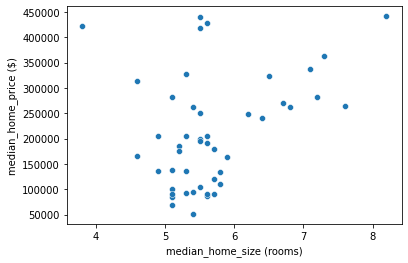

In [52]:
sns.scatterplot(x='median_home_size (rooms)',y='median_home_price ($)',data=df)

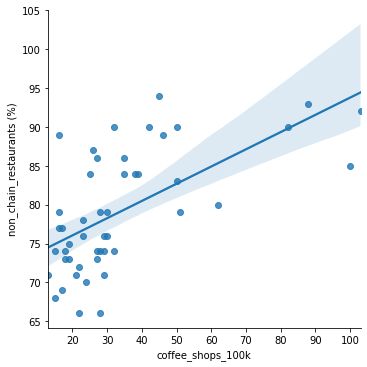

In [53]:
sns.lmplot(x='coffee_shops_100k',y='non_chain_restaurants (%)',data=df)

In [54]:
import helper_functions as h

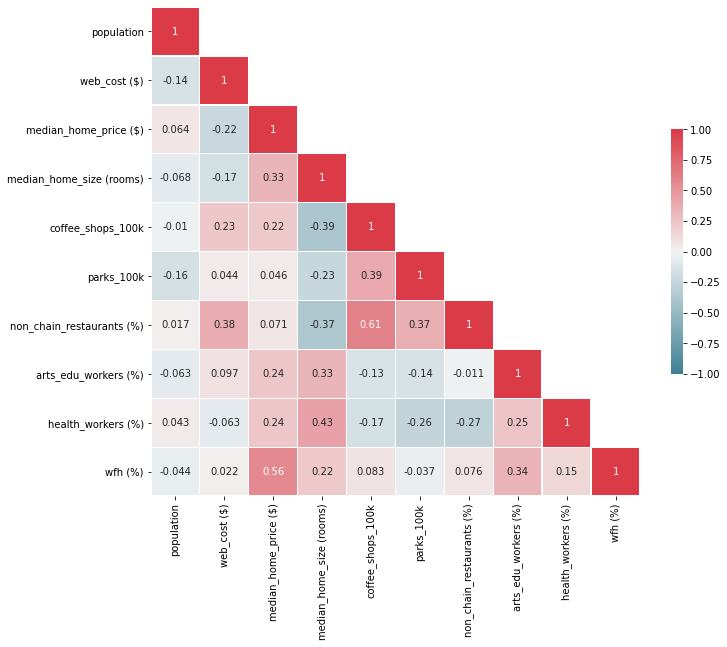

In [55]:
h.helpers.plot_corr_triangle(df.corr())